# Modelo para Análisis de sentimientos

### Importando librerías

In [2]:
import pandas as pd

import spacy

import nltk
from nltk.corpus import stopwords
from nltk import bigrams, trigrams, ngrams, skipgrams
from collections import defaultdict
from string import punctuation

from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Janneth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Janneth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Funciones

In [3]:
# Genera los tokens del texto y gestiona el uso de stopwords, signos de puntuación y lematización
def generador_tokens(text, remove_stopwords=False, lemmatize=False, remove_punctuation=False):

    # Tokenización
    tokens = word_tokenize(text)

    # Eliminar signos de puntuación
    if remove_punctuation:
        punctuations = list(punctuation)
        tokens = [word for word in tokens if word.isalnum() and word not in punctuations]

    # Eliminar stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('spanish'))
        tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    
    # Lematización
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

# Genera los n-gramas de un texto y realiza el conteo de frecuencias
def generador_grama(df, n, k, remove_stopwords=False, lemmatize=False, remove_punctuation=False):
  gram_generate = defaultdict(int)

  # Procesando cada opinión
  for row in df:
      opinion = row
      
      # Preprocesando el texto de la opinión y generador de tokens
      tokens = generador_tokens(opinion, remove_stopwords, lemmatize, remove_punctuation)
        
      # Generando n-gramas
      n_grams = ngrams(tokens, n)
      #n_grams = skipgrams(tokens, n, k)
        
      # Actualizando el puntaje de los n-gramas
      for gram in n_grams:
        gram_generate[gram] += 1
  
  return gram_generate

# Evaluación de un texto
# Regresa un score donde se suman las frecuencias de los n-gramas positivos y se restan las frecuencias de los n-gramas negativos
def evaluar_texto(texto, frec_positivos, frec_negativos, n, k):
    score = 0
    
    # Preprocesando el texto de la opinión y generador de tokens
    tokens = generador_tokens(texto, remove_stopwords=True, lemmatize=False, remove_punctuation=True)
    
    # Conteo de n-gramas 
    for n_grama in ngrams(tokens, n):
    #for n_grama in skipgrams(tokens, n, k):
        score += frec_positivos[n_grama]
        score -= frec_negativos[n_grama]
        #print(n_grama, "+", frec_positivos[n_grama], "-", frec_negativos[n_grama])     
    return score


# Clasificación del score
def clasificar(score):
    if score >= 0:  #Positivo
        return 1
    else:
        return 0    #Negativo

### Cargando conjuntos de entrenamiento y validación

In [4]:
train = pd.read_csv('../data/processed/train.csv', index_col=[0], parse_dates=['Date'], dayfirst=True)

val = pd.read_csv('../data/processed/val.csv', index_col=[0], parse_dates=['Date'], dayfirst=True)

### Separando por clase (Positivos y Negativos)

In [5]:
train_opiniones_positivas = train[train['Label'] == 1]['Opinion']

train_opiniones_negativas = train[train['Label'] == 0]['Opinion']

### Aplicando técnicas para el balanceo de clases

#### 1. Sobremuestreo de la clase minoritaria (Oversampling)

In [6]:
# Duplicar las reseñas de la clase minoritaria (negativos)
opiniones_negativas_duplicadas = train_opiniones_negativas.sample(n=len(train_opiniones_positivas) - len(train_opiniones_negativas), replace=True, random_state=42)

# Combinar el DataFrame original con las reseñas duplicadas
train_opiniones_negativas_balanceado = pd.concat([train_opiniones_negativas, opiniones_negativas_duplicadas])

print("Positivas: ", len(train_opiniones_positivas), " - Negativas: ", len(train_opiniones_negativas_balanceado))

Positivas:  2892  - Negativas:  2892


#### 2. Submuestreo de la clase mayoritaria (Undersampling)

In [7]:
# Realizar submuestreo de la clase mayoritaria para que tenga el mismo número de instancias que la clase minoritaria
#train_opiniones_positivas_balanceado = train_opiniones_positivas.sample(n=len(train_opiniones_negativas), random_state=42)
#train_opiniones_positivas_balanceado.shape


#### 3. Combinación oversampling + undersampling

In [8]:
## Calcular número de reseñas que deberán tener ambos conjuntos
#diff = len(train_opiniones_positivas) - len(train_opiniones_negativas)
#n_muestras = int(diff / 2)

#train_opiniones_positivas_balanceado = train_opiniones_positivas.sample(n=len(train_opiniones_positivas)-n_muestras, random_state=42)
#print(train_opiniones_positivas_balanceado.shape)

## Duplicar las reseñas de la clase minoritaria (negativos)
#opiniones_negativas_duplicadas = train_opiniones_negativas.sample(n=n_muestras, replace=True, random_state=42)


## Combinar el DataFrame original con las reseñas duplicadas
#train_opiniones_negativas_balanceado = pd.concat([train_opiniones_negativas, opiniones_negativas_duplicadas])

#train_opiniones_negativas_balanceado.shape

### Entrenamiento

In [9]:
# Número de n-gramas
n = 2

# Número de tokens a saltar, en caso de skip-grams
k = 1

# Modelo de conteos de n_gramas
frec_positivos = defaultdict(int) 
frec_negativos = defaultdict(int) 

frec_positivos = generador_grama(train_opiniones_positivas, n, k, remove_stopwords=True, lemmatize=False,remove_punctuation=True)
frec_negativos = generador_grama(train_opiniones_negativas_balanceado, n, k, remove_stopwords=True, lemmatize=False,remove_punctuation=True)

### Evaluación

In [10]:
# Evaluando un texto específico
#texto = 'el edificio esta en excelentes condiciones y las muestras son buenas guanajuato es esencial para comprender la historia de mexico y tambien lo son los muros y cuartos de la alhondiga que conserva en el silencio de sus muros y salas llantos conspiraciones politicas y piezas que trazan la arqueologia de nuestro pasado el museo es interesante pero el viajero debe poner todo de su parte para prender y hacer del recorrido una experiencia atractiva el museo tiene un gran reo por delante para captar la atencion de todo tipo de visitantes sin embargo hay guias muy buenos en la sala de exposicion de pinturas de milagros hay una guia excepcional ella transformo mi visita fue genial'
texto = 'es mas viejo que las momias'
evaluar_texto(texto, frec_positivos, frec_negativos, n, k)

1

In [11]:
# Evaluación de las opiniones del conjunto de validación
df_val_opiniones = val.copy()
df_val_opiniones['Score'] = df_val_opiniones['Opinion'].apply(lambda x: evaluar_texto(x, frec_positivos, frec_negativos, n, k))
df_val_opiniones['Clasificación'] = df_val_opiniones['Score'].apply(clasificar)

In [12]:
# F1 Score
from sklearn.metrics import f1_score
f1_score = f1_score(df_val_opiniones['Label'], df_val_opiniones['Clasificación'])
print(f'F1 Score:', f1_score)

F1 Score: 0.8535871156661786


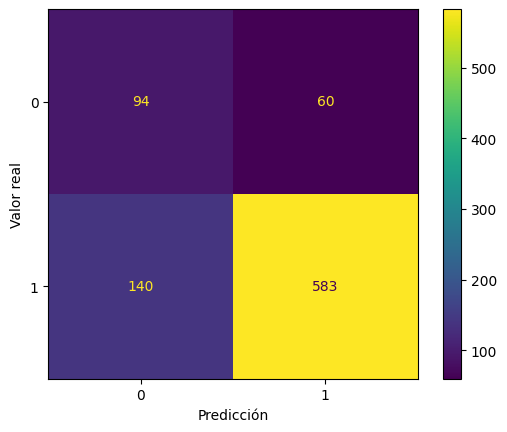

In [13]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(df_val_opiniones['Label'], df_val_opiniones['Clasificación'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.show()

In [14]:
# Classification Report
print(classification_report(df_val_opiniones['Label'], df_val_opiniones['Clasificación']))

              precision    recall  f1-score   support

           0       0.40      0.61      0.48       154
           1       0.91      0.81      0.85       723

    accuracy                           0.77       877
   macro avg       0.65      0.71      0.67       877
weighted avg       0.82      0.77      0.79       877



In [15]:
df_val_opiniones['Clasificación'].value_counts()

Clasificación
1    643
0    234
Name: count, dtype: int64

In [16]:
# Falsos positivos
falsos_positivos = df_val_opiniones[(df_val_opiniones['Label'] == 0) & (df_val_opiniones['Clasificación'] == 1)][['Title', 'Opinion', 'Place', 'Label','Score', 'Clasificación']]
falsos_positivos.head()

,Title,Opinion,Place,Label,Score,Clasificación
27,es mas viejo que las momias,en condiciones mediocres demasiado personal pa...,Museo de las Momias,0,3,1
35,historia,escultura importante que se encuentra sobre un...,Monumento Pípila,0,9,1
569,realismo magico,hay una leyenda acerca de este lugar que me pa...,Callejón del Beso,0,30,1
617,excelentes fotos panoramicas,este lugar es perfecto para tomar fotografias ...,Monumento Pípila,0,81,1
21,demasiado calor dentro de la estatua,no disfruto ir al pipila pero siendo de guanaj...,Monumento Pípila,0,11,1


In [17]:
# Falsos negativos
falsos_negativos = df_val_opiniones[(df_val_opiniones['Label'] == 1) & (df_val_opiniones['Clasificación'] == 0)][['Title', 'Opinion', 'Place', 'Label','Score', 'Clasificación']]
falsos_negativos.tail()

,Title,Opinion,Place,Label,Score,Clasificación
1407,interesante lugar,un museo muy interesante y diferente recomiend...,Museo de las Momias,1,-13,0
2578,templo con enorme belleza,me encanto su interior lleno de hermosura tant...,Basilica Colegiata,1,-20,0
3341,es una experiencia diferente,visite el museo de las momias con mi esposa y ...,Museo de las Momias,1,-68,0
834,estremecedor,perdi la cuenta de las veces que mi padre me l...,Museo de las Momias,1,-4,0
2838,interesante cuando es primera vez,es un buen lugar para conocer sobre museo y ma...,Museo de las Momias,1,-46,0


### Prueba

In [18]:
## Cargar el conjunto de prueba
#test = pd.read_csv('../data/raw/test.csv', index_col=[0], parse_dates=['Date'], dayfirst=True)

## Aplicar el modelo a las reseñas de prueba
#test['Score'] = test['Opinion'].apply(lambda x: evaluar_texto(x, frec_positivos, frec_negativos, n))
#test['Clasificación'] = test['Score'].apply(clasificar)

## F1 Score
#f1_score = f1_score(test['Label'], test['Clasificación'])
#print(f'F1 Score:', f1_score)

## Matriz de confusión
#cm = confusion_matrix(test['Label'], test['Clasificación'])
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#disp.plot()
#plt.xlabel('Predicción')
#plt.ylabel('Valor real')
#plt.show()

## Classification report
#print(classification_report(test['Label'], test['Clasificación']))